In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip -q '/content/drive/MyDrive/flowers/flowers.zip' -d '/content/flowers'

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import torchvision
import torchvision.transforms as tt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
class Arguments():
  def __init__(self, epochs = 16, batch_size = 8, image_size = 64, data_path = '', device = 'cuda', lr = 0.0002, num_samples = 4):
    self.epochs = epochs
    self.batch_size = batch_size
    self.image_size = image_size
    self.data_path = data_path
    self.device = device
    self.lr = lr
    self.num_samples = num_samples

args = Arguments()
args.epochs = 256
args.batch_size = 12
args.image_size = 64
args.dataset_path = "/content/flowers"
args.device = "cuda" if torch.cuda.is_available() else 'cpu'
args.lr = 0.0002
args.num_samples = 4    #EVEN

print(args.device)

cuda


In [43]:
class Diffusion():
  def __init__(self, time_steps = 500, beta_start = 0.0001, beta_stop = 0.02, image_size = 64, device = 'cuda'):
    self.time_steps = time_steps
    self.beta_start = beta_start
    self.beta_stop = beta_stop
    self.img_size = image_size
    self.device = device

    self.beta = self.beta_schedule()
    self.beta = self.beta.to(device)
    self.alpha = 1 - self.beta
    self.alpha = self.alpha.to(device)
    self.alpha_hat = torch.cumprod(self.alpha, dim = 0).to(device)


  def beta_schedule(self):
    return torch.linspace(self.beta_start, self.beta_stop, self.time_steps)

  def noise_images(self, images, t):
    sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None,]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None,]
    noises = torch.randn_like(images)
    noised_images = sqrt_alpha_hat * images + sqrt_one_minus_alpha_hat * noises
    return noised_images, noises

  def random_timesteps(self, n):
    return torch.randint(low=1, high=self.time_steps, size=(n,))

  def show_images(self, images):
    images = (images.clamp(-1, 1) + 1) / 2
    samples = images.size()[0]
    rows, cols = int(samples/2), int(samples/2)
    images = (images * 255).type(torch.uint8)
    j = 1
    for i in images:
      plt.subplot(rows, cols, j)
      plt.imshow(i.permute(1, 2, 0).cpu().detach().numpy())
      j += 1
    plt.show()

  def generate_samples(self, model, n, show = True):
    with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.time_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

    if show:
      self.show_images(x)
    return x
      #show_images

In [6]:
# class SelfAttention(nn.Module):
#     def __init__(self, channels, size):
#         super(SelfAttention, self).__init__()
#         self.channels = channels
#         self.size = size
#         self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
#         self.ln = nn.LayerNorm([channels])
#         self.ff_self = nn.Sequential(
#             nn.LayerNorm([channels]),
#             nn.Linear(channels, channels),
#             nn.GELU(),
#             nn.Linear(channels, channels),
#         )

#     def forward(self, x):
#         x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
#         x_ln = self.ln(x)
#         attention_value, _ = self.mha(x_ln, x_ln, x_ln)
#         attention_value = attention_value + x
#         attention_value = self.ff_self(attention_value) + attention_value
#         return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        # self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        # self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        # self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        # self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        # self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        # self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def positional_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, image, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.positional_encoding(t, self.time_dim)

        x1 = self.inc(image)
        x2 = self.down1(x1, t)
        # x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        # x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        # x = self.sa4(x)
        x = self.up2(x, x2, t)
        # x = self.sa5(x)
        x = self.up3(x, x1, t)
        # x = self.sa6(x)
        output = self.outc(x)
        return output

model = UNet(device = args.device).to(args.device)

In [23]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transforms = tt.Compose([ tt.Resize(args.image_size), tt.CenterCrop(args.image_size), tt.ToTensor(), tt.Normalize(*stats)])

class FlowerDescDataset(Dataset):
    def __init__(self, df, transform = transforms):
        self.df = df
        self.transform = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        img_name = self.df.iloc[index, 1]
        img_path = '/content/flowers/jpg/' + img_name
        img = Image.open(img_path)
        image=self.transform(img)
        return image

df = pd.read_csv('image_desc.csv')

dataset = FlowerDescDataset(df)
print(len(dataset))
dl = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, drop_last = True)

81890


In [39]:
def train(args):
    device = args.device
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(image_size=args.image_size, device=device)
    l = len(dl)
    print(l)

    for epoch in range(args.epochs):
        for images in tqdm(dl):
            sampled_images = diffusion.generate_samples(model, n=args.num_samples)
            images = images.to(device)
            t = diffusion.random_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)

            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        sampled_images = diffusion.generate_samples(model, n=args.num_samples)
        print(loss)



6824


499it [00:07, 67.37it/s]


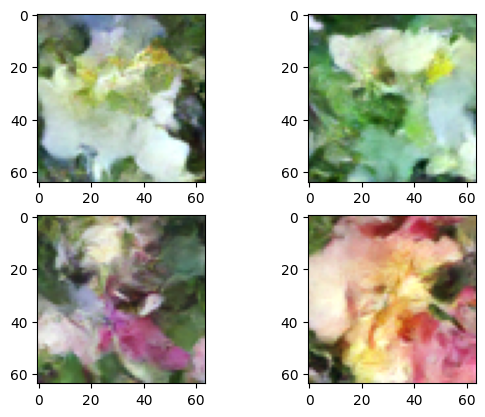

232it [00:03, 66.05it/s]
  0%|          | 1/6824 [00:11<22:05:09, 11.65s/it]


KeyboardInterrupt: ignored

In [44]:
train(args)